# The BHZ model and $\mathbb{Z}_2$ topological insulators

In [1]:
# usual imports
%pylab inline
from ipywidgets import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# definition of Pauli matrices in spin and sublattice space 
s0=t0=matrix([[1,0],[0,1]])
s1=t1=matrix([[0,1],[1,0]])
s2=t2=matrix([[0,-1j],[1j,0]])
s3=t3=matrix([[1,0],[0,-1]])
z2=zeros_like(s0);

## Ribbons

In [43]:
class ribbon:
    '''
    A class that holds information about a generic translationally inveriant ribbon.
    '''
    def __init__(self,Tx,Ty,U,L=10,kran=linspace(-pi,pi,314),**kwargs):
        '''
        Initialization
        '''
        self.L=L
        self.Tx=Tx
        self.Ty=Ty
        self.U=U
        self.kran=kran
        self.idf=Tx.shape[0]
        
    def build_kham(self,k,**kwargs):
        '''
        Build kspace Hamiltonian
        '''
        idL=matrix(eye(self.L))            # identity matrix of dimension L
        odL=matrix(diag(ones(self.L-1),1)) # upper off diagonal matrix with ones of size L
            
        H=(kron(idL,self.U)+
           kron(odL,self.Tx)+
           kron(odL,self.Tx).H+
           kron(idL,self.Ty)*exp(1.0j*k)+
           kron(idL,self.Ty).H*exp(-1.0j*k))
           
        return H
    
    def spectrdata(self,numLoc=2,norm_treshold=0.6,**kwargs):
        '''
        Get data to be plotted.
        '''
        self.dat=[]             # We will collect the data to be
        self.vecdat=[]          # plotted in these arrays.
        self.lefty=[]
        self.righty=[]
        for k in self.kran:
            H=self.build_kham(k)
            eigdat=eigh(H);       # for a given ky here we calculate the eigensystem (values and vectors)
            # finding and classifying edgestates
            for i in range(self.idf*self.L):
                    if sum(reshape(abs(array(eigdat[1][:,i]))**2,(self.L,self.idf))[:numLoc,:])>norm_treshold:
                        self.lefty=append(self.lefty,[[k,eigdat[0][i]]]);
                    if sum(reshape(abs(array(eigdat[1][:,i]))**2,(self.L,self.idf))[-numLoc:,:])>norm_treshold:
                        self.righty=append(self.righty,[[k,eigdat[0][i]]]);

            self.dat=append(self.dat,eigdat[0]);
            self.vecdat=append(self.vecdat,eigdat[1]);
    
        self.dat=reshape(self.dat,[len(self.kran),self.idf*self.L]);          # rewraping the data
        self.vecdat=reshape(self.vecdat,[len(self.kran),self.idf*self.L,self.idf*self.L]) # to be more digestable
        
    def plotenpsi(self,ki,n,**kwargs):
        '''
        Plot spectrum and charge density of a state.
        '''
        #figsize(14,5)
        subplot(121)
        lcol='#53a4d7'
        rcol='#d7191c'
        # Plotting the eigenvalues and 
        # a marker showing for which state 
        # we are exploring the wavefunction
        plot(self.kran,self.dat,'k-');            
        (lambda x:plot(x[:,0],x[:,1],'o',mec=lcol,mfc=lcol,
                   markersize=10))(reshape(self.lefty,(self.lefty.size/2,2)))
        (lambda x:plot(x[:,0],x[:,1],'o',mec=rcol,mfc=rcol,
                   markersize=5))(reshape(self.righty,(self.righty.size/2,2)))
        plot(self.kran[ki],self.dat[ki,n],'o',markersize=13,mec='k',mfc='w')
    
        # Make it look like the book    
        xlabel(r'wavenumber $k$',fontsize=25);        
        xticks(linspace(-pi,pi,5),[r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'],fontsize=25)
        ylabel(r'energy $E$',fontsize=25);
        yticks(fontsize=25)
        ylim(-2.99,2.99)
        xlim(-pi,pi)
        grid()

        subplot(122)
        # Plotting the sublattice resolved wavefunction
        dens=sum(reshape(abs(array(self.vecdat)[ki][:,n])**2,(self.L,self.idf)),axis=1)
        bar(arange(self.L),dens,color='grey');
    
        # Make it look like the book
        #xticks(2*(array(range(10))),['     '+str(i) for i in array(range(11))[1:]],fontsize=25)
        xticks(arange(self.L),['     '+str(i+1) for i in arange(self.L)],fontsize=25)
        ylim(0,1.2)
        yticks(linspace(0,1,3),fontsize=25,x=1.2)
        ylabel(r'density $|\psi|^2$',fontsize=25,labelpad=-460,rotation=-90)
        grid()
        
        xlabel(r'cell index $m$',fontsize=25);
        
        tight_layout()

               
               

In [44]:
u=s3;
t_x=(s3-1j*s1)/2;
t_y=(s3-1j*s2)/2;
t_x=kron((s0+s3)/2,t_x)+kron((s0-s3)/2,conj(t_x))
t_y=kron((s0+s3)/2,t_y)+kron((s0-s3)/2,conj(t_y))
u=kron(s0,u)

matrix([[ 0.+0.j,  0.-0.j,  0.+0.j,  0.-1.j],
        [ 0.+0.j,  0.+0.j,  0.+1.j,  0.+0.j],
        [ 0.+0.j,  0.-1.j,  0.+0.j,  0.-0.j],
        [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [73]:
BHZribbon=ribbon(t_x,t_y,-1.1*u+0.1*kron(s1,s2))
BHZribbon.spectrdata(norm_treshold=0.4)

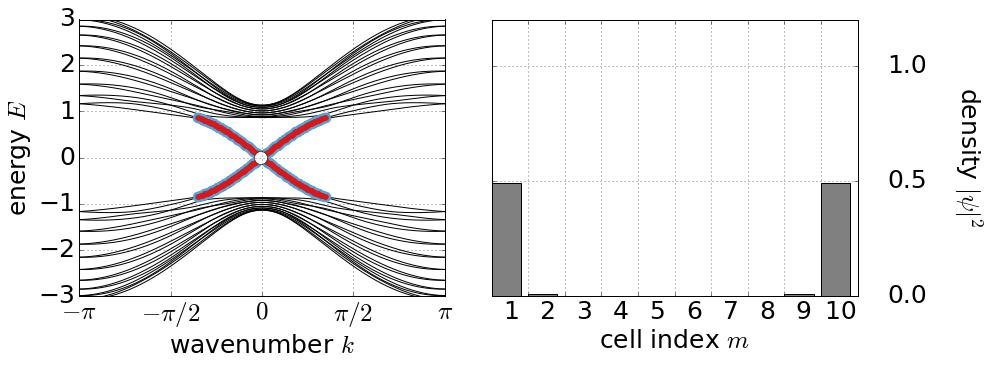

In [74]:
figsize(14,5)
interact(BHZribbon.plotenpsi,ki=(0,len(BHZribbon.kran)-1),n=(0,BHZribbon.L*BHZribbon.idf-1));

## Wilson loops and $\mathbb{Z}_2$ invariant

In [68]:
def BHZ(kx,ky,D,C):    
    H=(kron(s0,(D+cos(kx)+cos(ky))*s3+sin(ky)*s2) 
      +kron(s3,sin(kx)*s1) 
      +kron((s1+1.0j*s2)/2,C) 
      +kron((s1+1.0j*s2)/2,C).H );
    return H

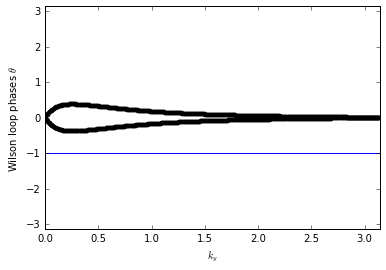

In [76]:
figsize(6,4)
for ky in linspace(0,pi,500):
    WL=eye(4)
    for kx in linspace(-pi,pi,5):
        H=BHZ(kx,ky,-2.1,z2)
        eigdat=eigh(H);
        eigdat[0]<0
        P=eigdat[1][:,eigdat[0]<0]*eigdat[1][:,eigdat[0]<0].H
        WL=P*WL
    weig=eig(WL);
    indx=where(abs(weig[0])>10**-10)[0]
    plot(ky*ones(len(indx)),angle(weig[0][indx]),'ko',ms=4)


plot([0,pi],[-1,-1],'b-')
ylim(-pi,pi)
xlim(0,pi)
xlabel(r'$k_y$') # 0 -pi pi
ylabel(r'Wilson loop phases $\theta$ ');